<br>

<h1 style="text-align:center;">Customer Support Bot</h1>


<br>

## Introduction

---

In this project, we will build a customer support bot for an airline to handle travel arrangements using LangGraph's tools. This project covers interrupts, checkpointers, and complex state management. 



In [4]:
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join('..')))

# Import all modules
from imports import *

In [8]:
# Load .env file
load_dotenv(dotenv_path='../.env')

True

<br>

## Sample Database

---

#### Databases

In [ ]:
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect('travel2.sqlite')

# Create a cursor object
cursor = conn.cursor()

# Retrieve the names of all tables in the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Iterate over each table and retrieve all rows
for table in tables:
	table_name = table[0]
	print(f"Contents of table {table_name}:")
	
	# Execute a query to retrieve all rows from the table
	cursor.execute(f"SELECT * FROM {table_name}")
	rows = cursor.fetchall()
	
	# Print the rows
	for row in rows:
		print(row)
	print("\n")

# Close the connection
conn.close()

In [9]:
# URLs and file paths
db_url = "https://storage.googleapis.com/benchmarks-artifacts/travel-db/travel2.sqlite"
local_file, backup_file = "travel2.sqlite", "travel2.backup.sqlite"

In [10]:
# Download the database if it doesn't exist locally
if not os.path.exists(local_file):
    with open(local_file, "wb") as f:
        f.write(requests.get(db_url).content)
    shutil.copy(local_file, backup_file)  # Create a backup of the database

In [11]:
# Connect to the SQLite database
conn = sqlite3.connect(local_file)

In [12]:
# Read all tables into a dictionary of DataFrames
tdf = {t: pd.read_sql(f"SELECT * from {t}", conn) for t in pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn).name}

In [13]:
### Update the tables to consider the current time

# Calculate the time difference between the current time and the latest actual departure time
example_time = pd.to_datetime(tdf["flights"]["actual_departure"].replace("\\N", pd.NaT)).max()
current_time = pd.to_datetime("now").tz_localize(example_time.tz)
time_diff = current_time - example_time

# Update the 'book_date' column in the 'bookings' table
tdf["bookings"]["book_date"] = pd.to_datetime(tdf["bookings"]["book_date"].replace("\\N", pd.NaT), utc=True) + time_diff

# Update datetime columns in the 'flights' table
for column in ["scheduled_departure", "scheduled_arrival", "actual_departure", "actual_arrival"]:
    tdf["flights"][column] = pd.to_datetime(tdf["flights"][column].replace("\\N", pd.NaT)) + time_diff

# Save the updated DataFrames back to the SQLite database
for table_name, df in tdf.items():
    df.to_sql(table_name, conn, if_exists="replace", index=False)

In [14]:
# Commit changes and close the connection
conn.commit()
conn.close()

In [15]:
# Set the local file as the database to be used in the tutorial
db = local_file

In [16]:
# Visualize all tables
for i_key, i_value in tdf.items():
    print(f'"{i_key}" table:')
    display(i_value.head())

"aircrafts_data" table:


,aircraft_code,model,range
0,773,Boeing 777-300,11100
1,763,Boeing 767-300,7900
2,SU9,Sukhoi Superjet-100,3000
3,320,Airbus A320-200,5700
4,321,Airbus A321-200,5600


"airports_data" table:


,airport_code,airport_name,city,coordinates,timezone
0,ATL,Hartsfield-Jackson Atlanta International Airport,Atlanta,"[33.6407, -84.4277]",America/New_York
1,PEK,Beijing Capital International Airport,Beijing,"[40.0799, 116.6031]",Asia/Shanghai
2,DXB,Dubai International Airport,Dubai,"[25.2532, 55.3657]",Asia/Dubai
3,LAX,Los Angeles International Airport,Los Angeles,"[33.9416, -118.4085]",America/Los_Angeles
4,HND,Tokyo Haneda Airport,Tokyo,"[35.5494, 139.7798]",Asia/Tokyo


"boarding_passes" table:


,ticket_no,flight_id,boarding_no,seat_no
0,0060005435212351,30625,1,2D
1,0060005435212386,30625,2,3G
2,0060005435212381,30625,3,4H
3,0060005432211370,30625,4,5D
4,0060005435212357,30625,5,11A


"bookings" table:


,book_ref,book_date,total_amount
0,00000F,2024-06-19 03:17:23.631769+00:00,265700
1,000012,2024-06-28 09:07:23.631769+00:00,37900
2,000068,2024-07-30 14:32:23.631769+00:00,18100
3,000181,2024-07-25 13:33:23.631769+00:00,131800
4,0002D8,2024-07-22 21:45:23.631769+00:00,23600


"flights" table:


,flight_id,flight_no,scheduled_departure,scheduled_arrival,departure_airport,arrival_airport,status,aircraft_code,actual_departure,actual_arrival
0,1185,QR0051,2024-08-25 05:55:23.631769-04:00,2024-08-25 11:00:23.631769-04:00,BSL,BKK,Scheduled,319,NaT,NaT
1,3979,MU0066,2024-08-09 10:55:23.631769-04:00,2024-08-09 13:40:23.631769-04:00,SHA,CUN,Scheduled,CR2,NaT,NaT
2,4739,QF0126,2024-08-20 08:35:23.631769-04:00,2024-08-20 10:20:23.631769-04:00,SHA,AMS,Scheduled,763,NaT,NaT
3,5502,LX0136,2024-08-27 05:55:23.631769-04:00,2024-08-27 07:25:23.631769-04:00,OSL,PRG,Scheduled,763,NaT,NaT
4,6938,IB0075,2024-08-19 08:30:23.631769-04:00,2024-08-19 09:25:23.631769-04:00,OSL,RGN,Scheduled,SU9,NaT,NaT


"seats" table:


,aircraft_code,seat_no,fare_conditions
0,319,2A,Business
1,319,2C,Business
2,319,2D,Business
3,319,2F,Business
4,319,3A,Business


"ticket_flights" table:


,ticket_no,flight_id,fare_conditions,amount
0,0060005432159776,30625,Business,42100
1,0060005435212351,30625,Business,42100
2,0060005435212386,30625,Business,42100
3,0060005435212381,30625,Business,42100
4,0060005432211370,30625,Business,42100


"tickets" table:


,ticket_no,book_ref,passenger_id
0,9880005432000987,06B046,8149 604011
1,9880005432000988,06B046,8499 420203
2,9880005432000989,E170C3,1011 752484
3,9880005432000990,E170C3,4849 400049
4,9880005432000991,F313DD,6615 976589


"car_rentals" table:


,id,name,location,price_tier,start_date,end_date,booked
0,1,Europcar,Basel,Economy,2024-04-14,2024-04-11,0
1,2,Avis,Basel,Luxury,2024-04-10,2024-04-20,0
2,3,Hertz,Zurich,Midsize,2024-04-10,2024-04-07,0
3,4,Sixt,Bern,SUV,2024-04-20,2024-04-26,0
4,5,Budget,Lucerne,Compact,2024-04-01,2024-04-19,0


"hotels" table:


,id,name,location,price_tier,checkin_date,checkout_date,booked
0,1,Hilton Basel,Basel,Luxury,2024-04-22,2024-04-20,0
1,2,Marriott Zurich,Zurich,Upscale,2024-04-14,2024-04-21,0
2,3,Hyatt Regency Basel,Basel,Upper Upscale,2024-04-02,2024-04-20,0
3,4,Radisson Blu Lucerne,Lucerne,Midscale,2024-04-24,2024-04-05,0
4,5,Best Western Bern,Bern,Upper Midscale,2024-04-23,2024-04-01,0


"trip_recommendations" table:


,id,name,location,keywords,details,booked
0,1,Basel Minster,Basel,"landmark, history","Visit the historic Basel Minster, a beautiful ...",0
1,2,Kunstmuseum Basel,Basel,"art, museum",Explore the extensive art collection at the Ku...,0
2,3,Zurich Old Town,Zurich,"history, architecture",Take a stroll through the charming streets of ...,0
3,4,Lucerne Chapel Bridge,Lucerne,"landmark, history",Walk across the iconic Chapel Bridge in Lucerne.,0
4,5,Bern Bear Park,Bern,"wildlife, park",Visit the Bern Bear Park and see the city's fa...,0


#### Company Policies (for RAG)

In [17]:
# Fetch the FAQ text from the given URL and split it into sections based on the pattern "\n##"
docs = [{"page_content": txt} for txt in re.split(r"(?=\n##)", requests.get("https://storage.googleapis.com/benchmarks-artifacts/travel-db/swiss_faq.md").text)]
docs

[{'page_content': '## Invoice Questions\n\n1. Can I receive an invoice for my booked flight?\n\nYes, we can send you a new booking confirmation free of charge for up to 100 days after the ticket/document has been completely used. A fee of CHF 30.00 per transaction (maximum of five E-ticket confirmations) will be charged after these 100 days. The E-ticket can be used for invoicing purposes.\n\n2. Do I need to reconfirm my flight?\n\nNo, reconfirmation of SWISS flights is not required.\n\n3. Can I check for availability and fares without booking a flight?\n\nYes, you can check flight availability and fares without finalizing a booking. The payment is only done in a last step, after entering your personal data.\n\n4. What are the flight tariff categories?\n\nThe letters B,E,G,H,K,L,M,Q,S,T,U,V,W,Y (Economy Class), C,D,J,P,Z (Business Class), and A,F (First Class) are used to indicate the different price categories in the different service classes.\n\n5. Where can I find the fare condition

<br>

## Tools

---

Next, define our assistant's tools to search the airline's policy manual and search and manage reservations for flights, hotels, car rentals, and excursions. We will reuse these tools throughout the tutorial. The exact implementations
aren't important, so feel free to run the code below and jump to [Part 1](#part-1-zero-shot).



#### 01. Lookup Company Policies

The assistant retrieve policy information to answer user questions. Note that _enforcement_ of these policies still must be done within the tools/APIs themselves, since the LLM can always ignore this.

In [18]:
class VectorStoreRetriever:

    def __init__(self, docs, vectors, oai_client):
        self._arr, self._docs, self._client = np.array(vectors), docs, oai_client
    
    @classmethod
    def from_docs(cls, docs, oai_client):
        embeddings = oai_client.embeddings.create(model="text-embedding-3-large", input=[doc["page_content"] for doc in docs])
        return cls(docs, [emb.embedding for emb in embeddings.data], oai_client)
    
    def query(self, query: str, k: int = 5) -> list[dict]:
        embed = self._client.embeddings.create(model="text-embedding-3-large", input=[query])
        scores = np.array(embed.data[0].embedding) @ self._arr.T
        top_k_idx = np.argpartition(scores, -k)[-k:]
        return [{"page_content": self._docs[idx]["page_content"], "similarity": scores[idx]} 
                for idx in top_k_idx[np.argsort(-scores[top_k_idx])]]
    
retriever = VectorStoreRetriever.from_docs(docs, openai.Client())

In [13]:
# import numpy as np
# from langchain_community.llms import Ollama
# import ollama
# class VectorStoreRetriever:
#     def __init__(self, docs, vectors, ollama_client):
#         self._arr, self._docs, self._client = np.array(vectors), docs, ollama_client
#     @classmethod
#     def from_docs(cls, docs, ollama_client):
#         embeddings = [ollama.embeddings(model="llama3", prompt=doc["page_content"])["embedding"] for doc in docs]
#         return cls(docs, embeddings, ollama_client)
#     def query(self, query: str, k: int = 5) -> list[dict]:
#         query_embedding = ollama.embeddings(model="llama3", prompt=query)["embedding"]
#         scores = np.dot(self._arr, query_embedding)
#         top_k_idx = np.argpartition(scores, -k)[-k:]
#         return [{"page_content": self._docs[idx]["page_content"], "similarity": scores[idx]} 
#                 for idx in top_k_idx[np.argsort(-scores[top_k_idx])]]
# llm_client = Ollama(model="llama3")

# retriever = VectorStoreRetriever.from_docs(docs, llm_client)

In [14]:
# This will be used inide a tool named lookup_policy

#### 06. Utilities

Define helper functions to pretty print the messages in the graph while we debug it and to give our tool node error handling (by adding the error to the chat history).

In [19]:
def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {"messages": [ToolMessage(content=f"Error: {repr(error)}\n please fix your mistakes.", tool_call_id=tc["id"]) for tc in tool_calls]}

def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks([RunnableLambda(handle_tool_error)], exception_key="error")

def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

<br>

## Graph States

---

In [20]:
def update_dialog_stack(left: list[str], right: Optional[str]) -> list[str]:
    """Push or pop the state."""
    if right is None:
        return left
    if right == "pop":
        return left[:-1]
    return left + [right]

In [21]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str
    dialog_state: Annotated[list[Literal["assistant", "update_flight", "book_car_rental", "book_hotel", "book_excursion"]], update_dialog_stack,]

<br>

## Assistants

---

We will create an assistant for each of the following workflow:
1. Flight booking assistant
2. Hotel booking assistant
3. Car rental assistant
4. Excursion assistant
5. A "primary assistant" to route between these

In [23]:
# LLM model
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama3-8b-8192")

In [24]:
class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)

            if not result.tool_calls and (not result.content or isinstance(result.content, list) and not result.content[0].get("text")):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

#### Flight booking assistant


In [25]:
# Flight booking assistant

# Prompt
flight_booking_prompt = enigma_code.prompts.flight_booking_prompt

# Safe tools
update_flight_safe_tools = [search_flights]

# Sensitive tools
update_flight_sensitive_tools = [update_ticket_to_new_flight, cancel_ticket]

# Other tools
update_flight_tools = update_flight_safe_tools + update_flight_sensitive_tools

# Chain
update_flight_runnable = flight_booking_prompt | llm.bind_tools(update_flight_tools + [CompleteOrEscalate])

#### Hotel Booking Assistant


In [26]:
# Hotel Booking Assistant

# Prompt
book_hotel_prompt = enigma_code.prompts.book_hotel_prompt

# Safe tools
book_hotel_safe_tools = [search_hotels]

# Sensitive tools
book_hotel_sensitive_tools = [book_hotel, update_hotel, cancel_hotel]

# Other tools
book_hotel_tools = book_hotel_safe_tools + book_hotel_sensitive_tools

# Chain
book_hotel_runnable = book_hotel_prompt | llm.bind_tools(book_hotel_tools + [CompleteOrEscalate])

#### Car Rental Assistant


In [27]:
# Car Rental Assistant

# Prompt
book_car_rental_prompt = enigma_code.prompts.book_hotel_prompt

# Safe tools
book_car_rental_safe_tools = [search_car_rentals]

# Sensitive tools
book_car_rental_sensitive_tools = [book_car_rental, update_car_rental, cancel_car_rental,]

# Other tools
book_car_rental_tools = book_car_rental_safe_tools + book_car_rental_sensitive_tools

# Chain
book_car_rental_runnable = book_car_rental_prompt | llm.bind_tools(book_car_rental_tools + [CompleteOrEscalate])

#### Excursion Assistant


In [28]:
# Excursion Assistant

# Prompt
book_excursion_prompt = enigma_code.prompts.book_excursion_prompt

# Safe tools
book_excursion_safe_tools = [search_trip_recommendations]

# Sensitive tools
book_excursion_sensitive_tools = [book_excursion, update_excursion, cancel_excursion]

# Other tools
book_excursion_tools = book_excursion_safe_tools + book_excursion_sensitive_tools

# Chain
book_excursion_runnable = book_excursion_prompt | llm.bind_tools(book_excursion_tools + [CompleteOrEscalate])

#### Primary Assistant


In [29]:
# Primary Assistant

# Prompt
primary_assistant_prompt = enigma_code.prompts.primary_assistant_prompt

# Tools
primary_assistant_tools = [TavilySearchResults(max_results=1), search_flights, lookup_policy]

# Other tools
primary_assistant_all_tools = llm.bind_tools(primary_assistant_tools + [ToFlightBookingAssistant, ToBookCarRental, ToHotelBookingAssistant, ToBookExcursion])

# Chain
assistant_runnable = primary_assistant_prompt | primary_assistant_all_tools

<br>

## Utility

---

Create a function to make an "entry" node for each workflow, stating "the current assistant ix `assistant_name`".

In [30]:
def create_entry_node(assistant_name: str, new_dialog_state: str) -> Callable:
    def entry_node(state: State) -> dict:
        tool_call_id = state["messages"][-1].tool_calls[0]["id"]
        return {
            "messages": [
                ToolMessage(
                    content=f"The assistant is now the {assistant_name}. Reflect on the above conversation between the host assistant and the user."
                    f" The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are {assistant_name},"
                    " and the booking, update, other other action is not complete until after you have successfully invoked the appropriate tool."
                    " If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control."
                    " Do not mention who you are - just act as the proxy for the assistant.",
                    tool_call_id=tool_call_id,
                )
            ],
            "dialog_state": new_dialog_state,
        }

    return entry_node

<br>

## Define Graph

---

Now it's time to start building our graph. As before, we'll start with a node to pre-populate the state with the user's current information.

In [31]:
# Initialize the graph builder
builder = StateGraph(State)

In [32]:
# User info node
def user_info(state: State):
    return {"user_info": fetch_user_flight_information.invoke({})}

# Add nodes
builder.add_node("fetch_user_info", user_info)

# Add edges
builder.add_edge(START, "fetch_user_info")

#### Flight booking assistant


In [33]:
# Add nodes
builder.add_node("enter_update_flight", create_entry_node("Flight Updates & Booking Assistant", "update_flight"),)
builder.add_node("update_flight", Assistant(update_flight_runnable))
builder.add_node("update_flight_sensitive_tools", create_tool_node_with_fallback(update_flight_sensitive_tools),)
builder.add_node("update_flight_safe_tools", create_tool_node_with_fallback(update_flight_safe_tools),)

# Add edges
builder.add_edge("enter_update_flight", "update_flight")
builder.add_edge("update_flight_sensitive_tools", "update_flight")
builder.add_edge("update_flight_safe_tools", "update_flight")

In [34]:
# Add conditional edge

def route_update_flight(state: State,) -> Literal["update_flight_sensitive_tools", "update_flight_safe_tools", "leave_skill", "__end__",]:
    route = tools_condition(state)

    # If ended
    if route == END:
        return END
    
    # If cancelled
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    
    # If all safe tools were called
    safe_toolnames = [t.name for t in update_flight_safe_tools]
    if all(tc["name"] in safe_toolnames for tc in tool_calls):
        return "update_flight_safe_tools"
    
    # If all sensitive tools were called
    return "update_flight_sensitive_tools"

builder.add_conditional_edges("update_flight", route_update_flight)

In [35]:
# This node will be shared for exiting all specialized assistants
def pop_dialog_state(state: State) -> dict:
    """Pop the dialog stack and return to the main assistant.
    This lets the full graph explicitly track the dialog flow and delegate control
    to specific sub-graphs.
    """
    messages = []
    if state["messages"][-1].tool_calls:
        # Note: Doesn't currently handle the edge case where the llm performs parallel tool calls
        messages.append(
            ToolMessage(
                content="Resuming dialog with the host assistant. Please reflect on the past conversation and assist the user as needed.",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        )
    return {
        "dialog_state": "pop",
        "messages": messages,
    }
builder.add_node("leave_skill", pop_dialog_state)
builder.add_edge("leave_skill", "primary_assistant")

#### Car rental assistant

Next, create the **car rental assistant** graph to own all car rental needs.

In [36]:
# Add nodes
builder.add_node("enter_book_car_rental", create_entry_node("Car Rental Assistant", "book_car_rental"),)
builder.add_node("book_car_rental", Assistant(book_car_rental_runnable))
builder.add_node("book_car_rental_safe_tools", create_tool_node_with_fallback(book_car_rental_safe_tools))
builder.add_node("book_car_rental_sensitive_tools", create_tool_node_with_fallback(book_car_rental_sensitive_tools),)

# Add edges
builder.add_edge("enter_book_car_rental", "book_car_rental")
builder.add_edge("book_car_rental_sensitive_tools", "book_car_rental")
builder.add_edge("book_car_rental_safe_tools", "book_car_rental")

In [37]:
# Add conditional edge

def route_book_car_rental(state: State) -> Literal["book_car_rental_safe_tools", "book_car_rental_sensitive_tools", "leave_skill", "__end__",]:
    route = tools_condition(state)

    # If ended
    if route == END:
        return END
    
    # If cancelled
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    
    # If all safe tools were called
    safe_toolnames = [t.name for t in book_car_rental_safe_tools]
    if all(tc["name"] in safe_toolnames for tc in tool_calls):
        return "book_car_rental_safe_tools"
    
    # If all sensitive tools were called
    return "book_car_rental_sensitive_tools"

builder.add_conditional_edges("book_car_rental", route_book_car_rental)

#### Hotel booking assistant

Then define the **hotel booking** workflow.

In [38]:
# Add nodes
builder.add_node("enter_book_hotel", create_entry_node("Hotel Booking Assistant", "book_hotel"))
builder.add_node("book_hotel", Assistant(book_hotel_runnable))
builder.add_node("book_hotel_safe_tools", create_tool_node_with_fallback(book_hotel_safe_tools),)
builder.add_node("book_hotel_sensitive_tools", create_tool_node_with_fallback(book_hotel_sensitive_tools),)

# Add edges
builder.add_edge("enter_book_hotel", "book_hotel")
builder.add_edge("book_hotel_sensitive_tools", "book_hotel")
builder.add_edge("book_hotel_safe_tools", "book_hotel")

In [39]:
# Add conditional edge

def route_book_hotel(state: State) -> Literal["leave_skill", "book_hotel_safe_tools", "book_hotel_sensitive_tools", "__end__"]:
    route = tools_condition(state)

    # If ended
    if route == END:
        return END
    
    # If cancelled
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    
    # If all safe tools were called
    tool_names = [t.name for t in book_hotel_safe_tools]
    if all(tc["name"] in tool_names for tc in tool_calls):
        return "book_hotel_safe_tools"
    
    # If sensitive tools were called
    return "book_hotel_sensitive_tools"

builder.add_conditional_edges("book_hotel", route_book_hotel)

#### Excursion assistant

After that, define the **excursion assistant**.

In [40]:
# Add nodes
builder.add_node("enter_book_excursion",create_entry_node("Trip Recommendation Assistant", "book_excursion"),)
builder.add_node("book_excursion", Assistant(book_excursion_runnable))
builder.add_node("book_excursion_safe_tools", create_tool_node_with_fallback(book_excursion_safe_tools),)
builder.add_node("book_excursion_sensitive_tools", create_tool_node_with_fallback(book_excursion_sensitive_tools),)

# Add edges
builder.add_edge("enter_book_excursion", "book_excursion")
builder.add_edge("book_excursion_sensitive_tools", "book_excursion")
builder.add_edge("book_excursion_safe_tools", "book_excursion")

In [41]:
# Add conditional edges

def route_book_excursion(state: State) -> Literal["book_excursion_safe_tools", "book_excursion_sensitive_tools", "leave_skill", "__end__",]:
    route = tools_condition(state)

    # If ended
    if route == END:
        return END
    
    # If cancelled
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    
    # If all safe tools were called
    tool_names = [t.name for t in book_excursion_safe_tools]
    if all(tc["name"] in tool_names for tc in tool_calls):
        return "book_excursion_safe_tools"
    
    # If sensitive tools were called
    return "book_excursion_sensitive_tools"

builder.add_conditional_edges("book_excursion", route_book_excursion)

#### Primary assistant

Finally, create the **primary assistant**.

In [42]:
# Add nodes
builder.add_node("primary_assistant", Assistant(assistant_runnable))
builder.add_node("primary_assistant_tools", create_tool_node_with_fallback(primary_assistant_tools))

In [43]:
def route_primary_assistant(state: State) -> Literal["primary_assistant_tools", "enter_update_flight", "enter_book_hotel", "enter_book_excursion", "__end__",]:
    route = tools_condition(state)

    # If ended
    if route == END:
        return END
    
    # If specific assistant tools were called
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:

        # Flight booking assistant
        if tool_calls[0]["name"] == ToFlightBookingAssistant.__name__:
            return "enter_update_flight"
        
        # Car rental assistant
        elif tool_calls[0]["name"] == ToBookCarRental.__name__:
            return "enter_book_car_rental"
        
        # Hotel booking assistant
        elif tool_calls[0]["name"] == ToHotelBookingAssistant.__name__:
            return "enter_book_hotel"
        
        # Excursion assistant
        elif tool_calls[0]["name"] == ToBookExcursion.__name__:
            return "enter_book_excursion"
        
    # If primary assistant tools were called
        return "primary_assistant_tools"
    
    # If no tools were called
    raise ValueError("Invalid route")

In [44]:
# The assistant can route to one of the delegated assistants, directly use a tool, or directly respond to the user
builder.add_conditional_edges(
    "primary_assistant",
    route_primary_assistant,
    {
        "enter_update_flight": "enter_update_flight",
        "enter_book_car_rental": "enter_book_car_rental",
        "enter_book_hotel": "enter_book_hotel",
        "enter_book_excursion": "enter_book_excursion",
        "primary_assistant_tools": "primary_assistant_tools",
        END: END,
    },
)
builder.add_edge("primary_assistant_tools", "primary_assistant")

In [45]:
# Each delegated workflow can directly respond to the user. When the user responds, we want to return to the currently active workflow
def route_to_workflow(state: State) -> Literal["primary_assistant", "update_flight", "book_car_rental", "book_hotel", "book_excursion",]:
    """If we are in a delegated state, route directly to the appropriate assistant."""
    dialog_state = state.get("dialog_state")
    if not dialog_state:
        return "primary_assistant"
    return dialog_state[-1]

builder.add_conditional_edges("fetch_user_info", route_to_workflow)

In [46]:
# Compile graph
memory = SqliteSaver.from_conn_string(":memory:")
part_4_graph = builder.compile(
    checkpointer=memory,
    # Let the user approve or deny the use of sensitive tools
    interrupt_before=["update_flight_sensitive_tools", "book_car_rental_sensitive_tools", "book_hotel_sensitive_tools", "book_excursion_sensitive_tools",],
)

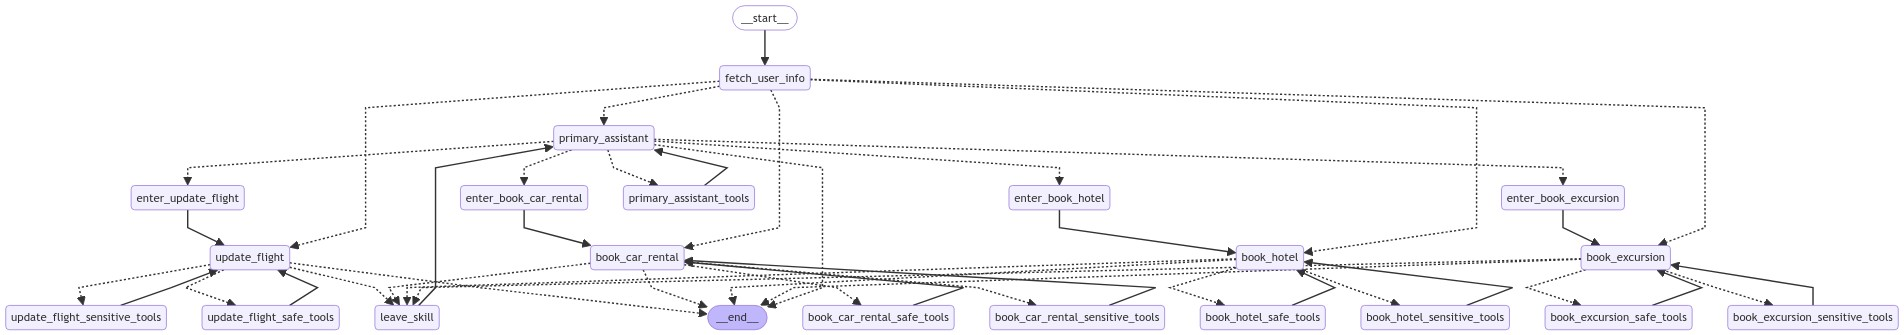

In [47]:
# Generate the image
image_data = part_4_graph.get_graph(xray=True).draw_mermaid_png()

# Save the image to a file
with open("graph.png", "wb") as f:
	f.write(image_data)

# Optionally, display the image in the notebook
display(Image(image_data, width=1200, height=2000))

<br>

## Conversation

---

That was a lot! Let's run it over the following list of dialog turns. This time, we'll have many fewer confirmations.

In [48]:
# List of questions to ask the assistant
tutorial_questions = [
    "Hi, what's my user information?",
    "Hi there, what time is my flight?",
    "Am i allowed to update my flight to something sooner? I want to leave later today.",
    "Update my flight to sometime next week then",
    "The next available option is great",
    "what about lodging and transportation?",
    "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    "OK could you place a reservation for your recommended hotel? It sounds nice.",
    "Now for a car, what are my options?",
    "yes go ahead and book anything that's moderate expense and has availability.",
    "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    "Cool so now what recommendations do you have on excursions?",
    "Are they available while I'm there?",
    "interesting - i like the museums, what options are there? ",
    "OK great pick one and book it for my second day there.",
]

In [49]:
# Backup file for the database
shutil.copy(backup_file, db)
thread_id = str(uuid.uuid4())

# Configuration 
config = {
    "configurable": {
        "passenger_id": "3442 587242",          # The passenger_id is used in our flight tools to fetch the user's flight information
        "thread_id": thread_id,                 # Checkpoints are accessed by thread_id
    }
}

# Set of printed messages
_printed = set()

# Loop over the questions
for question in tutorial_questions:

    # Stream the events
    events = part_4_graph.stream({"messages": ("user", question)}, config, stream_mode="values")
    for event in events:
        _print_event(event, _printed)

    # Get the current state
    snapshot = part_4_graph.get_state(config)

    # Handle the interrupt
    while snapshot.next:

        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it. Note: This code is all outside of your graph. Typically, you would stream the output to a UI. Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        user_input = input(
            "Do you approve of the above actions? Type 'y' to continue;"
            " otherwise, explain your requested changed.\n\n"
        )

        # If user approves, continue
        if user_input.strip() == "y":
            result = part_4_graph.invoke(None, config)

        # If user denies, provide reasoning
        else:
            # Satisfy the tool invocation by providing instructions on the requested changes / change of mind
            result = part_4_graph.invoke(
                {"messages": [
                    ToolMessage(tool_call_id=event["messages"][-1].tool_calls[0]["id"], content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",)
                    ]
                }, config)
            
        # Stream the events
        snapshot = part_4_graph.get_state(config)

================================ Human Message =================================

Hi, what's my user information?
================================== Ai Message ==================================

Welcome to Swiss Airlines! I'd be happy to help you with any questions or concerns you may have. According to our system, your flight information is as follows:

<Flights>
[
  {
    "ticket_no": "7240005432906569",
    "book_ref": "C46E9F",
    "flight_id": 19250,
    "flight_no": "LX0112",
    "departure_airport": "CDG",
    "arrival_airport": "BSL",
    "scheduled_departure": "2024-04-30 12:09:03.561731-04:00",
    "scheduled_arrival": "2024-04-30 13:39:03.561731-04:00",
    "seat_no": "18E",
    "fare_conditions": "Economy"
  }
]
</Flights>

Please note that this information is subject to change, and I recommend verifying it with your booking reference or contacting our customer service team if you have any questions or concerns.

Now, how can I assist you today?
===========================